Modified from the [original](https://github.com/willyhagi/climate-data-science) by [spestana](https://github.com/spestana/climate-data-science)

Companion Jupyter Notebook to the [MODIS Vegetation Indices: a GEE Approach](https://towardsdatascience.com/modis-vegetation-indices-a-gee-approach-f48e1259e462) article, published in Towards Data Science.

# Importing

In [1]:
import ee 
import folium
import geehydro
import numpy as np
import pandas as pd
import proplot as plot 
import matplotlib.pyplot as plt 

from ipygee import *
from pandas.plotting import register_matplotlib_converters

# Authentication

In [2]:
# Initialize the library.
ee.Initialize()

# Set our Area of Interest (AOI)

In [3]:
clearlake_aoi = ee.Geometry.Rectangle([-121.0, 41.95,
                                   -121.3, 41.75])

In [4]:
clearlake_aoi.getInfo()

{'type': 'Polygon',
 'coordinates': [[[-121.3, 41.75],
   [-121, 41.75],
   [-121, 41.95],
   [-121.3, 41.95],
   [-121.3, 41.75]]]}

In [5]:
Map = folium.Map(location=[41.85, -121.13], zoom_start=8)
#Map.setOptions('HYBRID')
Map.addLayer(clearlake_aoi)
Map

# MODIS MOD13Q1 Vegetation Indices

In [6]:
# MODIS MOD13Q1
modis = ee.ImageCollection('MODIS/006/MOD13Q1').filterDate(ee.DateRange('2016-01-01',
                                                                        '2019-12-01'))

In [7]:
# select EVI and NDVI
evi = modis.select('EVI')
ndvi = modis.select('NDVI')

In [8]:
def scale_factor(image):
  # scale factor for the MODIS MOD13Q1 product
  return image.multiply(0.0001).copyProperties(image, ['system:time_start'])

In [9]:
# mapping function to multiply by the scale factor
scaled_evi = evi.map(scale_factor)
scaled_ndvi = ndvi.map(scale_factor)

In [10]:
# mean NDVI around clearlake
# For EVI, just do scaled_evi_mean().clip(clearlake_aoi)
Map.addLayer(scaled_ndvi.mean().clip(clearlake_aoi),
             vis_params={'min': 0,
                         'max': 1,
                         'palette': ['red', 'yellow', 'green']})
Map

In [11]:
# Xingu MOD13Q1 NDVI time series
clearlake_ndvi = chart.Image.series(**{'imageCollection': scaled_ndvi,
                                   'region': clearlake_aoi,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})
clearlake_ndvi.renderWidget(width='50%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [12]:
type(clearlake_ndvi.dataframe)

pandas.core.frame.DataFrame

In [13]:
# Xingu MOD13Q1 EVI time series
clearlake_evi = chart.Image.series(**{'imageCollection': scaled_evi,
                                   'region': clearlake_aoi,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})
clearlake_evi.renderWidget(width='50%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

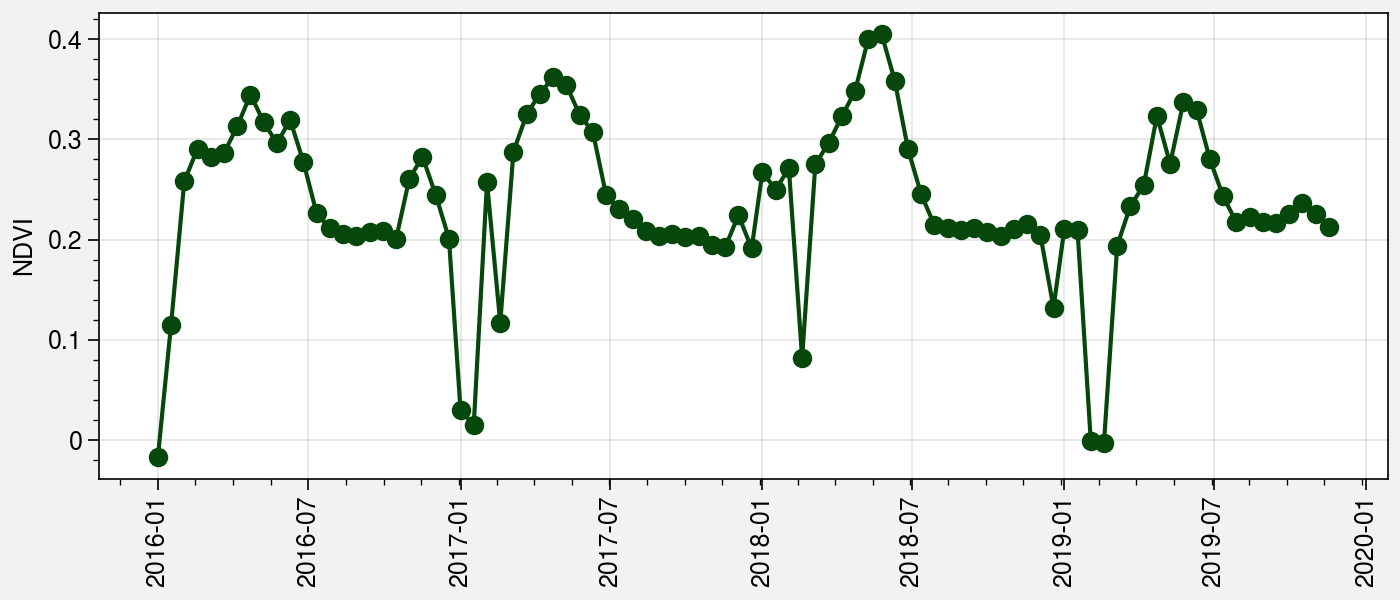

In [14]:
fig, ax = plot.subplots(figsize=(7, 3), tight=True)
ax.plot(clearlake_ndvi.dataframe.index, clearlake_ndvi.dataframe['NDVI'],
        color='forest green', marker='o')
plot.show()

In [15]:
# monthly averaging
clearlake_evi_monthly = clearlake_evi.dataframe.groupby(pd.Grouper(freq="M")).mean()
clearlake_ndvi_monthly = clearlake_ndvi.dataframe.groupby(pd.Grouper(freq="M")).mean()

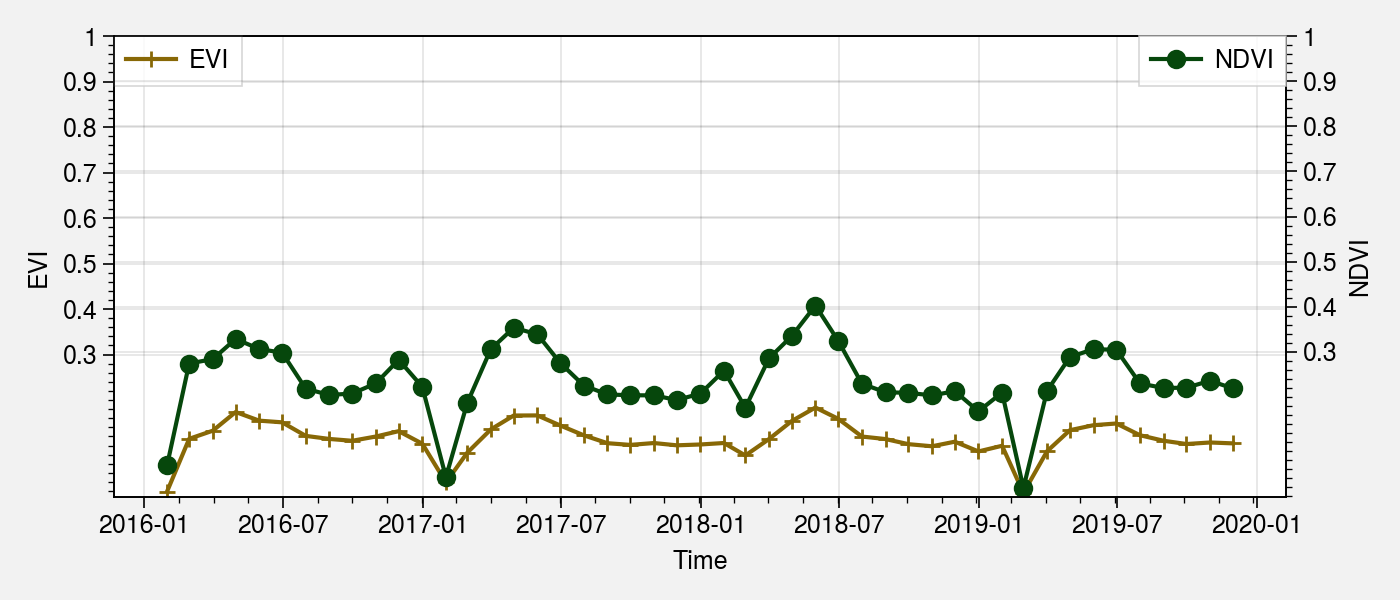

In [16]:
# time index 
time = clearlake_evi_monthly.index

# plot
fig, ax1 = plt.subplots(figsize=(7, 3))
ax2 = ax1.twinx()

ax1.plot(time, clearlake_evi_monthly, label='EVI',
         color='muddy brown', marker='+')
ax2.plot(time, clearlake_ndvi_monthly, label='NDVI',
         color='forest green', marker='o')

ax1.set_xlabel('Time')
ax1.set_ylabel('EVI')
ax2.set_ylabel('NDVI')

ax1.set_yticks(np.arange(0.3, 1.1, 0.1))
ax2.set_yticks(np.arange(0.3, 1.1, 0.1))

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()